In [8]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

ERROR:root:Line magic function `%install_ext` not found.


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 7.14 ms


In [9]:
%pylab inline
from snakebite.client import Client
import pyaml as yaml
import sys
import pythonrun
reload(pythonrun)
import os
import seaborn as sns
from sklearn import metrics
import scala_python_endive_wrapper
reload(scala_python_endive_wrapper)
from scala_python_endive_wrapper import *
import pandas as pd

Populating the interactive namespace from numpy and matplotlib
time: 16.6 ms


/home/eecs/vaishaal/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['linalg', 'random', 'power', 'info', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
hdfsclient = Client("amp-spark-master.amp", 8020, use_trash=False)
notebook_stdout = sys.stdout
notebook_stderr = sys.stderr
terminal_stdout = open('/dev/stdout', 'w')
terminal_stderr = open('/dev/stderr', 'w')
logpath = "/tmp/log"

time: 6.56 ms


In [11]:

executor_mem = "200g"
cores_per_executor = 32
num_executors = 14

time: 2.67 ms


In [6]:
# CHANGE ME
dataset_creation_config = \
{
    "labels": "/user/vaishaal/endive-data/ChIPseq/labels/EGR1.train.labels.tsv", \
    "reference": "/home/eecs/akmorrow/ADAM/endive/workfiles/hg19.2bit", \
    "dnase": "/user/vaishaal/endive-data/DNASE/peaks/relaxed/", \
    "aggregatedSequenceOutput": "/user/vaishaal/endive-data/aggregated/EGR1/"
}

EGR1_PATH = "/user/vaishaal/endive-data/aggregated/EGR1/EGR1"
ATF2_PATH = "/user/vaishaal/endive-data/aggregated/ATF2/ATF2"


time: 5.02 ms


In [12]:
# Run scala job send output to terminal to create windows
sys.stdout = terminal_stdout
sys.stderr = terminal_stderr
pythonrun.run(dataset_creation_config, 
              logpath,
              dataset_creation_pipeline_class, 
              pipeline_jar, 
              executor_mem,
              cores_per_executor, 
              num_executors,
              use_yarn=True)

TypeError: run() got an unexpected keyword argument 'executor_mem'

In [ ]:
# this is where the magic happens
results = [] 
negs = []
for neg in [0.001,0.01, 0.1, 1.0]:
     res = run_kernel_pipeline(EGR1_PATH,
                           "/tmp/filters.csv", 
                           logpath, 
                           seed=0,
                           gamma=1.0,
                           negativeSamplingFreq=neg,
                           filter_gen_gen=make_gaussian_filter_gen,
                           executor_mem=executor_mem)
     negs.append(neg)
     results.append(res)

## 

#### ROC Metrics

In [16]:
df_base = []
for i,res in enumerate(results):
    ((y_train, y_train_pred), (y_test, y_test_pred)) = res
    result = {}
    neg = negs[i]
    sys.stdout = notebook_stdout
    sys.stderr = notebook_stderr
    train_roc_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_roc_auc = metrics.roc_auc_score(y_test, y_test_pred)
    train_pr_auc = metrics.average_precision_score(y_train, y_train_pred)
    test_pr_auc = metrics.average_precision_score(y_test, y_test_pred)
    result['gamma'] = 1.0
    result['train_roc'] = train_roc_auc
    result['test_roc'] = test_roc_auc
    result['train_pr'] = train_pr_auc
    result['test_pr'] = test_pr_auc
    result['seed'] = 0
    result['neg'] = neg
    df_base.append(result)

In [17]:
df = pd.DataFrame(df_base)

time: 4.41 ms


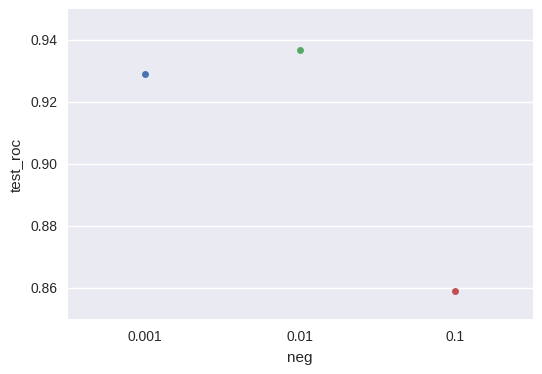

time: 245 ms


In [21]:
sns.stripplot(x='neg', y='test_roc', data=df)

#### PR Metrics

Train PR AUC 0.757754546452
Test PR AUC 0.121105773929


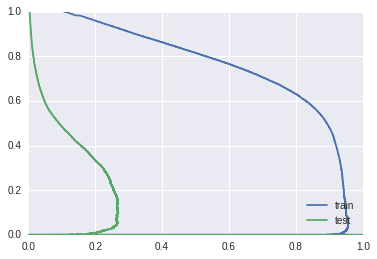

time: 2.96 s


In [68]:
sys.stdout = notebook_stdout
sys.stderr = notebook_stderr
fpr, tpr, thresh = metrics.precision_recall_curve(y_train, y_train_pred)
train_auc = metrics.average_precision_score(y_train, y_train_pred)
plot(fpr, tpr, label="train")

fpr, tpr, thresh = metrics.precision_recall_curve(y_test, y_test_pred)
test_auc = metrics.average_precision_score(y_test, y_test_pred)

plot(fpr, tpr, label="test")

plt.legend(loc=4)
plt.figure()
print("Train PR AUC {0}".format(train_auc))
print("Test PR AUC {0}".format(test_auc))

In [15]:
print "POTATO"

In [19]:
print negs

[0.001, 0.01, 0.1]
time: 1.63 ms
